In [1]:
import seaborn as sns
from adaptive_CI.compute import collect
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import norm
from time import time
from glob import glob
import scipy.stats as stats
from IPython.display import display, HTML
from adaptive_CI.saving import *
import  pickle
from pickle import UnpicklingError
import copy
from itertools import compress
import scipy.stats as stats
from plot_utils import *

sns.set_context("notebook", font_scale=1.3)

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [9]:
def plot_contrast(df,
                  row_order=['nosignal', 'lowSNR', 'highSNR'],
                  col_order=['mse', 'bias', 'CI_width', '90% coverage of t-stat'],
                  col_names=['RMSE', 'bias', 'confidence interval width', '90% coverage'],
                  hue_order=['uniform', 'propscore', 'lvdl', 'two_point', 'two_point_old', 'bernstein'], 
                  labels=['uniform', 'propscore', 'constant', 'two-point (NEW)', 'two-point (OLD)', 'bernstein'],
                  name=None):
    """
    Plot RMSE, bias and 90% coverage of t-statisitcs in cases of no-signal and high-SNR across different weighting schemes.
    """
    palette = sns.color_palette("muted")[:len(hue_order)]
    g = sns.catplot(x="T",
                    y="value",
                    col="statistic",
                    col_order=col_order,
                    row="dgp",
                    row_order=row_order,
                    hue='method',
                    hue_order=hue_order,
                    palette=palette,
                    kind="point",
                    sharex=False,
                    sharey=False,
                    legend=False,
                    legend_out=True,
                    margin_titles=True,
                    data=df)

    # Plot ROOT mse
    for i, dgp in enumerate(row_order): 
        g.axes[i, 0].clear()
        sns.pointplot(x='T',
                      y="value",
                      hue='method',
                      hue_order=hue_order,
                      palette=palette,
                      ax=g.axes[i, 0],
                      data=df.query(f"statistic=='mse' & dgp=='{dgp}'"),
                      estimator=lambda x: np.sqrt(np.mean(x)),
                      markers="")
        g.axes[i, 0].get_legend().remove()
    g.axes[0, 0].set_xlabel("")
    g.axes[0, 0].set_ylabel("")


    # Add row and column names
    g.row_names = ['NO SIGNAL', 'LOW-SIGNAL', 'HIGH SNR']
    g.col_names = col_names

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="")
    g.set_titles(row_template="{row_name}", col_template="{col_name}")

    g.axes[0, -1].axhline(0.90, color="black", linestyle='--')
    g.axes[1, -1].axhline(0.90, color="black", linestyle='--')

    g.axes[0, 1].axhline(0, color="black", linestyle='--')
    g.axes[1, 1].axhline(0, color="black", linestyle='--')
    g.axes[0, 0].axhline(0, color="black", linestyle='--')
    g.axes[1, 0].axhline(0, color="black", linestyle='--')

    g.fig.tight_layout()

    # Add legend
    handles, ls = g._legend_data.values(), g._legend_data.keys()
    label_dict = dict(zip(hue_order, labels))
    labels = [label_dict[k] for k in ls]
    g.fig.legend(labels=labels,
                 handles=handles, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, 0.0))

    g.set_xlabels("")
    g.set_ylabels("")
    g.fig.tight_layout()

    g.fig.subplots_adjust(bottom=0.1)

    if name is not None:
        plt.savefig(f'figures/{name}.pdf', bbox_inches='tight')
    plt.show()


In [11]:
def plot_converged_statistics2(df,
                               col_order=['mse', 'bias', 'CI_width', '90% coverage of t-stat'],
                               row_order=[2, 0],
                               hue='method',
                               hue_order=['uniform', 'propscore', 'lvdl', 'two_point', 'two_point_old', 'bernstein'], 
                               labels=['uniform', 'propscore', 'constant allocation rate', 'two-point (NEW)', 'two-point (OLD)', 'bernstein'],
                               noise_func='uniform', 
                               name=None):
    """
    Plot converged RMSE and bias of bad arm and good arm across different weighting schemes.
    """
    palette = sns.color_palette("muted")[:len(hue_order)]

    order = ['nosignal', 'lowSNR', f'highSNR']
    order_name = ['NO SIGNAL', 'LOW SNR', 'HIGH SNR']
    g = sns.catplot(x="dgp",
                    y="value",
                    order=order,
                    hue='method',
                    hue_order=hue_order,
                    palette=palette,
                    col="statistic",
                    col_order=col_order,
                    row="policy",
                    row_order=row_order,
                    kind="point",
                    sharex=False,
                    sharey=False, #'col',
                    legend=False,
                    legend_out=True,
                    margin_titles=True,
                    data=df)

    # Plot RMSE of bad arm based on MSE
    for i, arm in enumerate(row_order):
        g.axes[i, 0].clear()
        sns.pointplot(x='dgp',
                      y="value",
                      order=order,
                      hue='method',
                      hue_order=hue_order,
                      palette=palette,
                      ax=g.axes[i, 0],
                      data=df.query(f"policy=={arm} & statistic=='mse'"),
                      estimator=lambda x: np.sqrt(np.mean(x)),
                      )
        g.axes[i, 0].get_legend().remove()
        g.axes[i, 0].set_xlabel("")
        g.axes[i, 0].set_ylabel("")


    # Add row and column names
    g.col_names = ['RMSE', 'bias', 'confidence interval width', '90% coverage']
    g.row_names = ['BAD ARM', 'GOOD ARM']

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="")
    g.set_titles(row_template="{row_name}", col_template="{col_name}")

    # Set xticklabels to be [NO SIGNAL, LOW SIGNAL and HIGH SIGNAL]
    for ax in g.axes.flat:
        ax.set_xticklabels(order_name)

    g.axes[0, 1].axhline(0, color="black", linestyle='--')
    g.axes[1, 1].axhline(0, color="black", linestyle='--')

    g.axes[0, -1].axhline(0.90, color="black", linestyle='--')
    g.axes[1, -1].axhline(0.90, color="black", linestyle='--')

    # Add legend
    handles, ls = g._legend_data.values(), g._legend_data.keys()
    label_dict = dict(zip(hue_order, labels))
    labels = [label_dict[k] for k in ls]
    g.fig.legend(labels=labels,
                 handles=handles, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.01))

    g.set_xlabels("")
    g.set_ylabels("")

    g.fig.tight_layout()
    g.fig.subplots_adjust(bottom=0.1)
    if name is not None:
        plt.savefig(f'figures/{name}.pdf', bbox_inches='tight')
    plt.show()

### Load data

In [4]:
files = glob("results/*.pkl")
print(f"Found {len(files)} files")
df = []
for file in files:
    try:
        df.append(pd.read_pickle(file))
    except Exception as e:
        print("Error when reading file {file}")
df = pd.concat(df)
print("Loaded")

Found 100 files
Loaded


In [5]:
df['value'] = df['value'].astype(float)

In [6]:
decay_rates = np.sort(df['floor_decay'].unique())

----

# Arm values

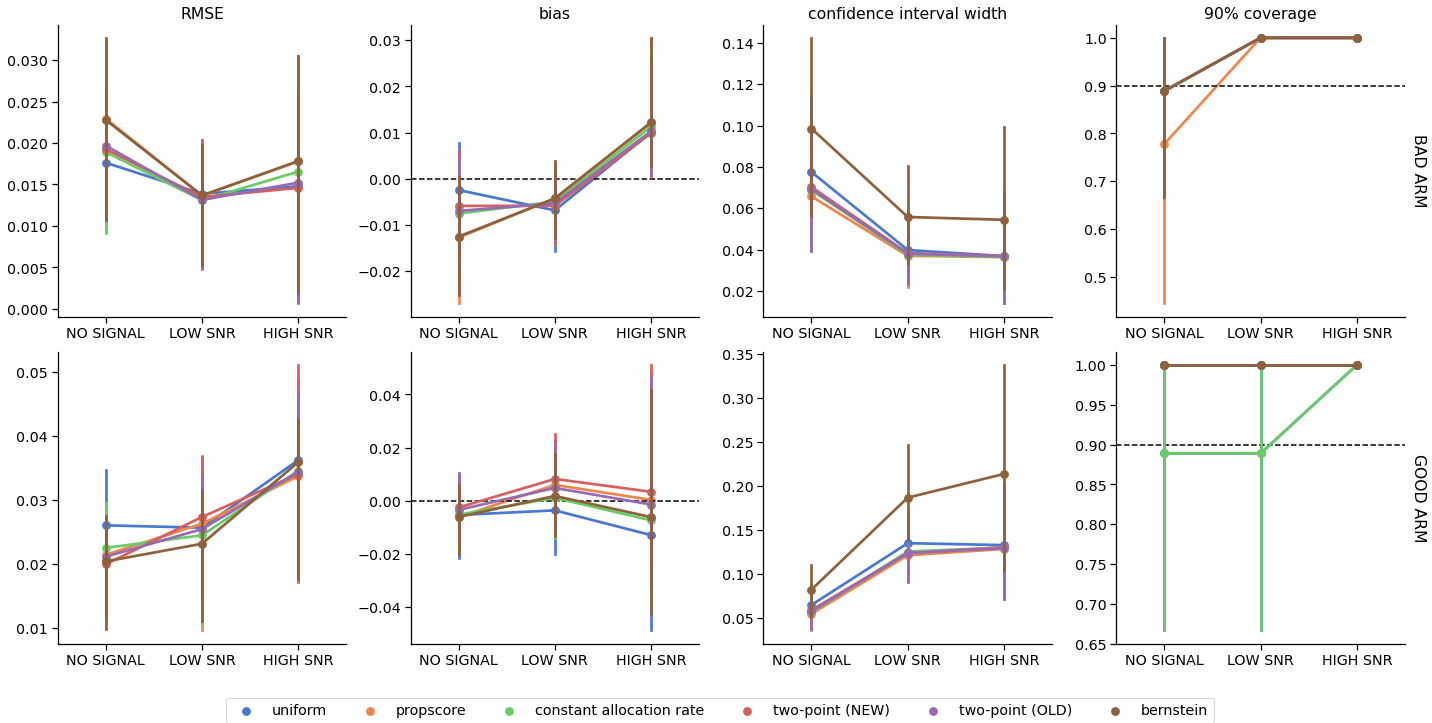

KeyboardInterrupt: 

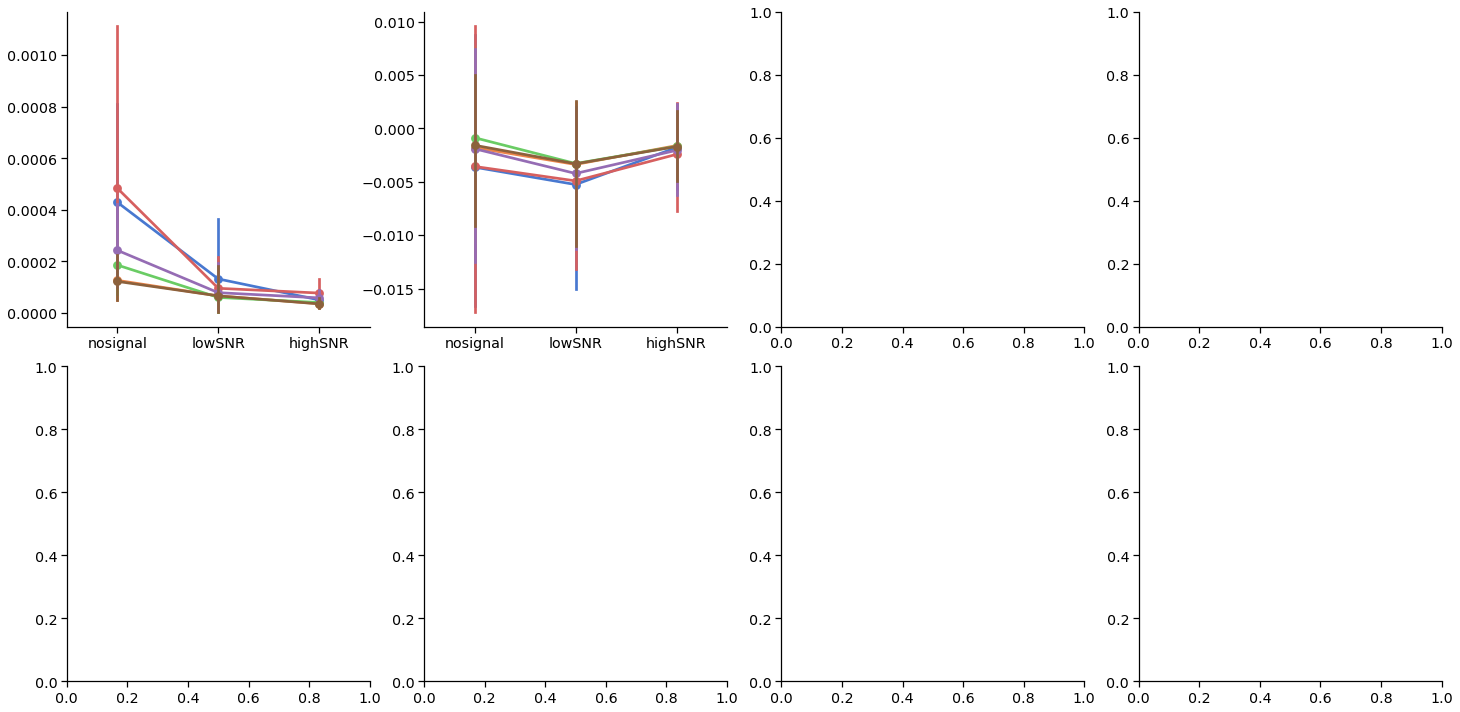

In [12]:
for alpha in decay_rates:
    display(HTML(f"<h2>Decay rate (alpha) = {alpha}</h2>"))
    plot_converged_statistics2(df.query(f"floor_decay=={alpha}"))

---

# Contrasts

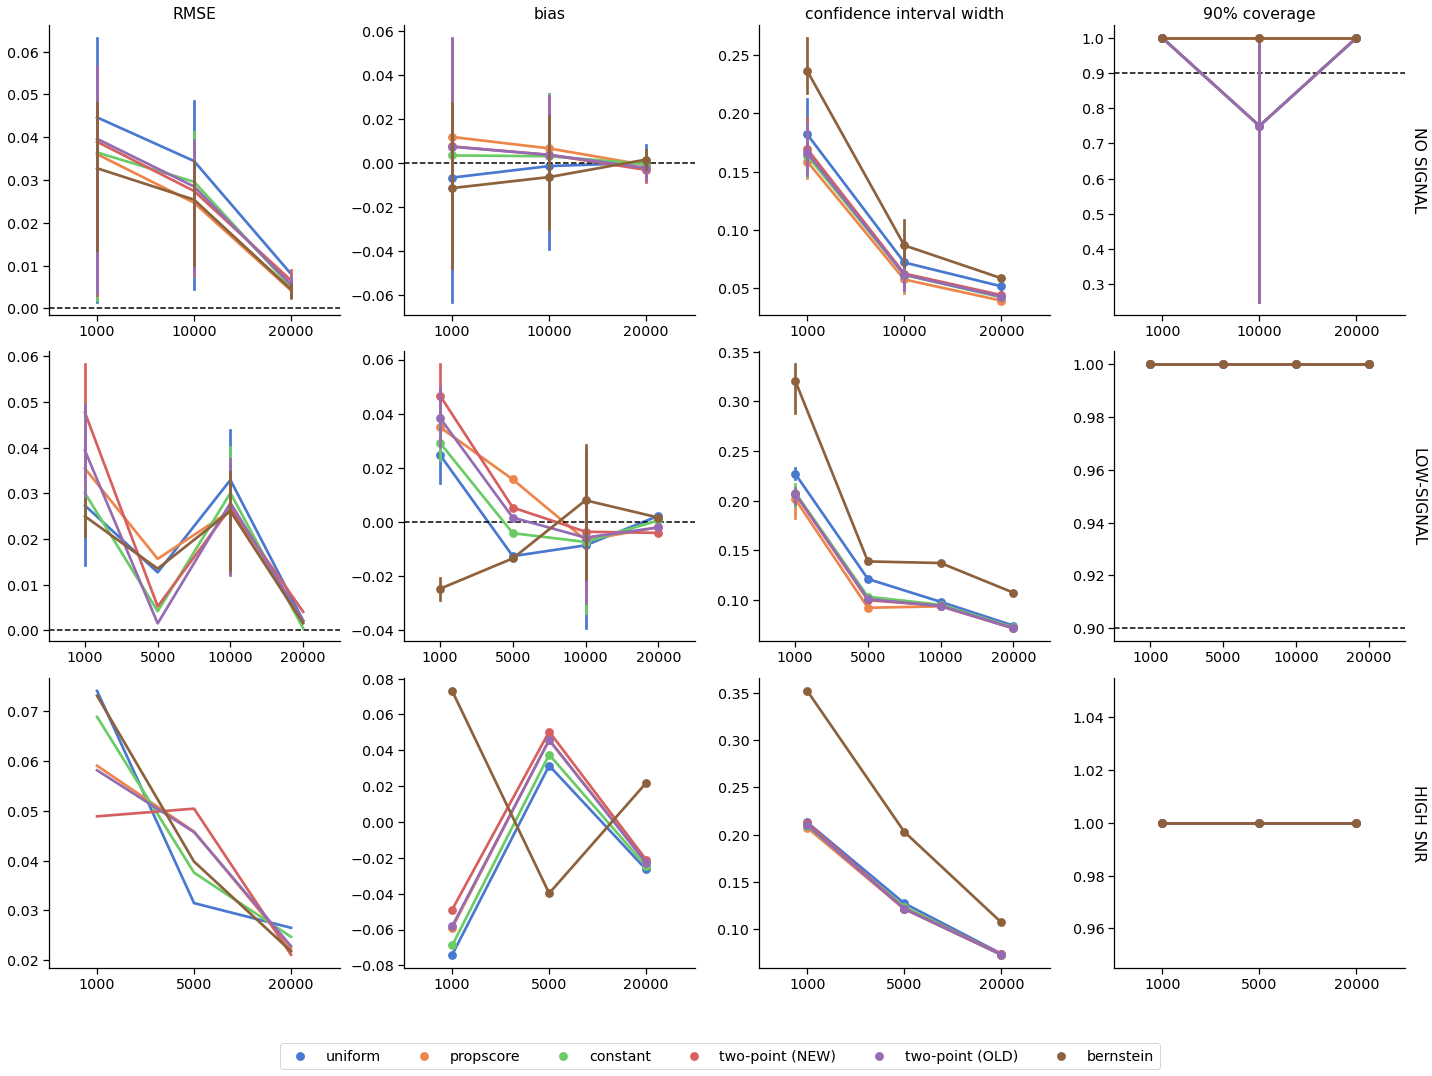

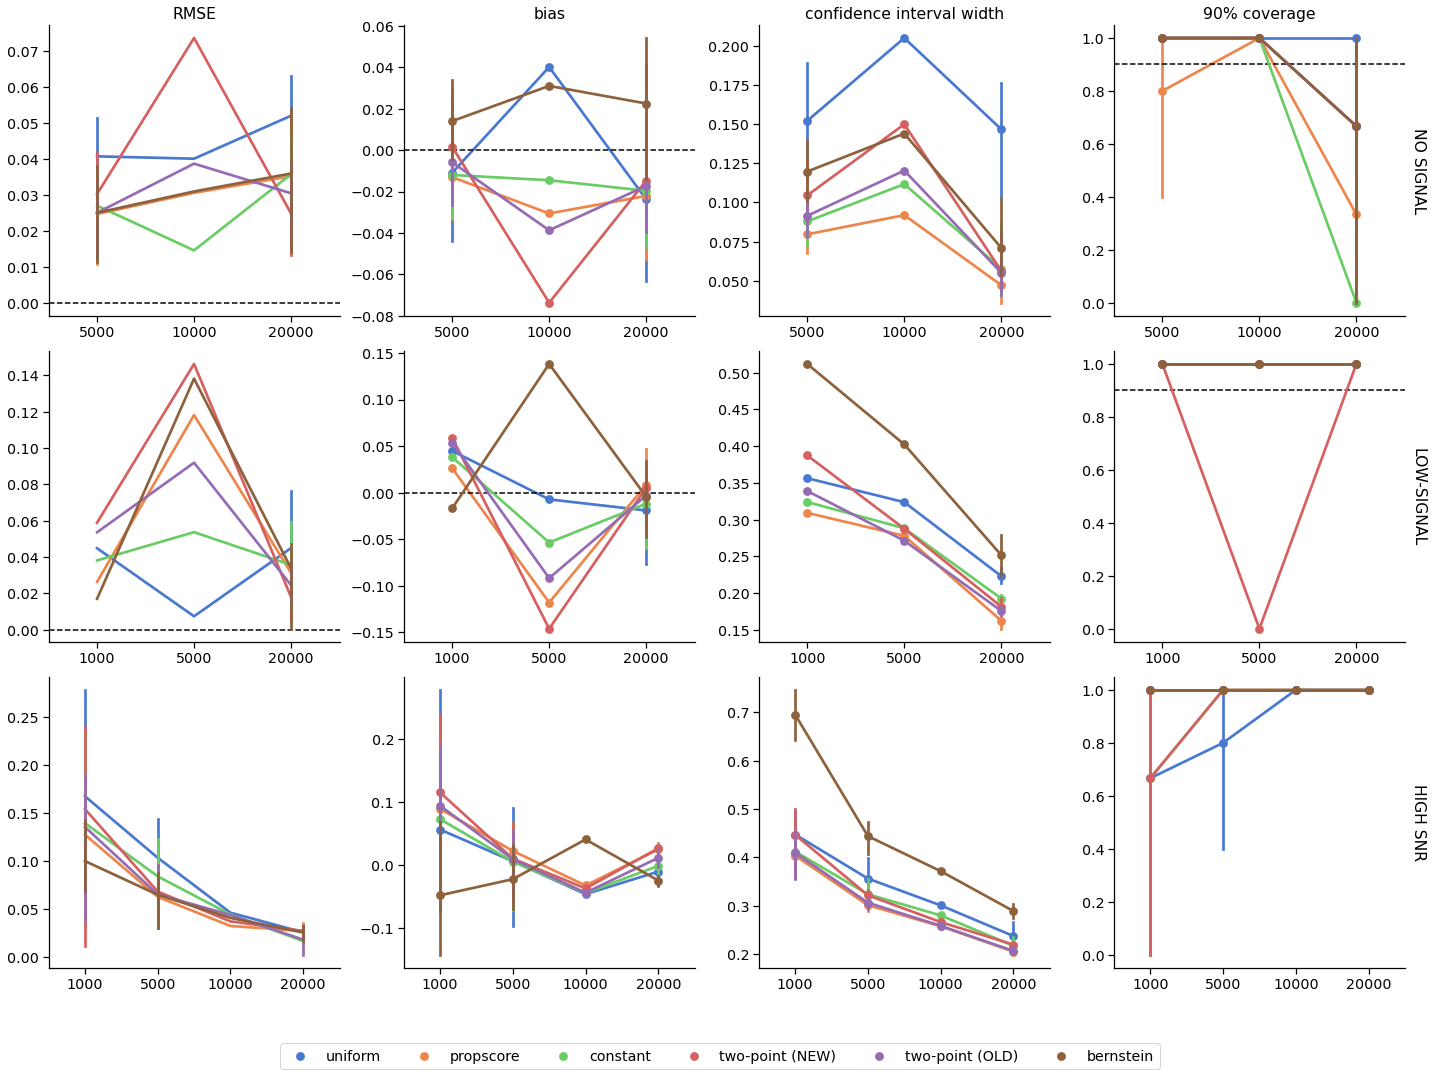

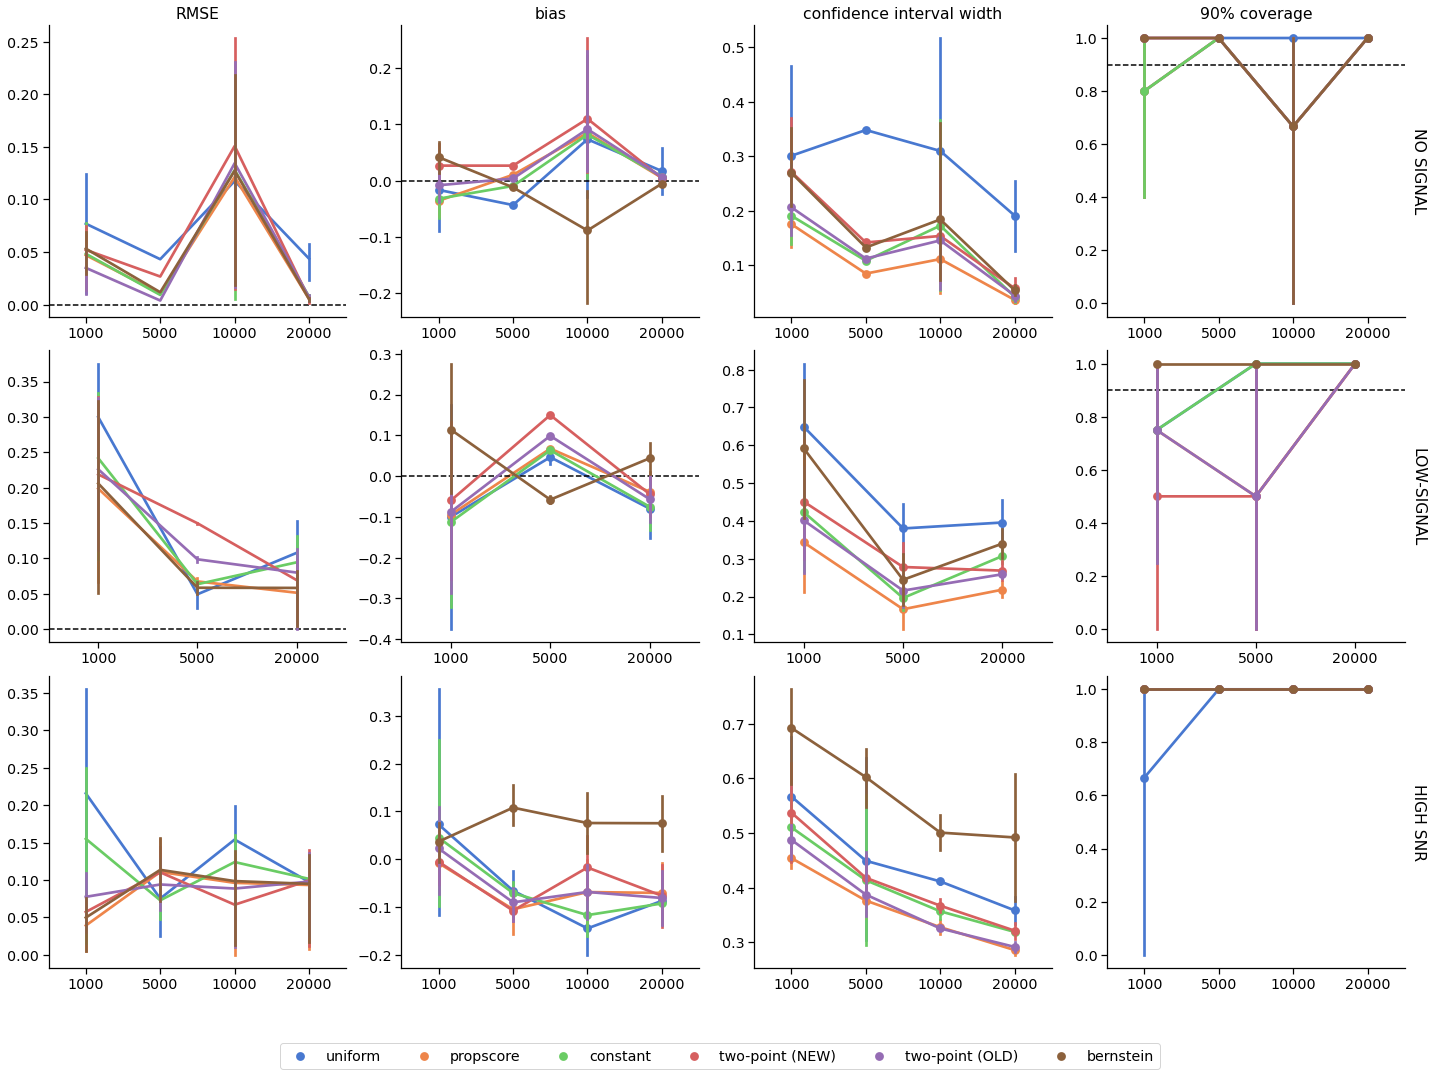

KeyboardInterrupt: 

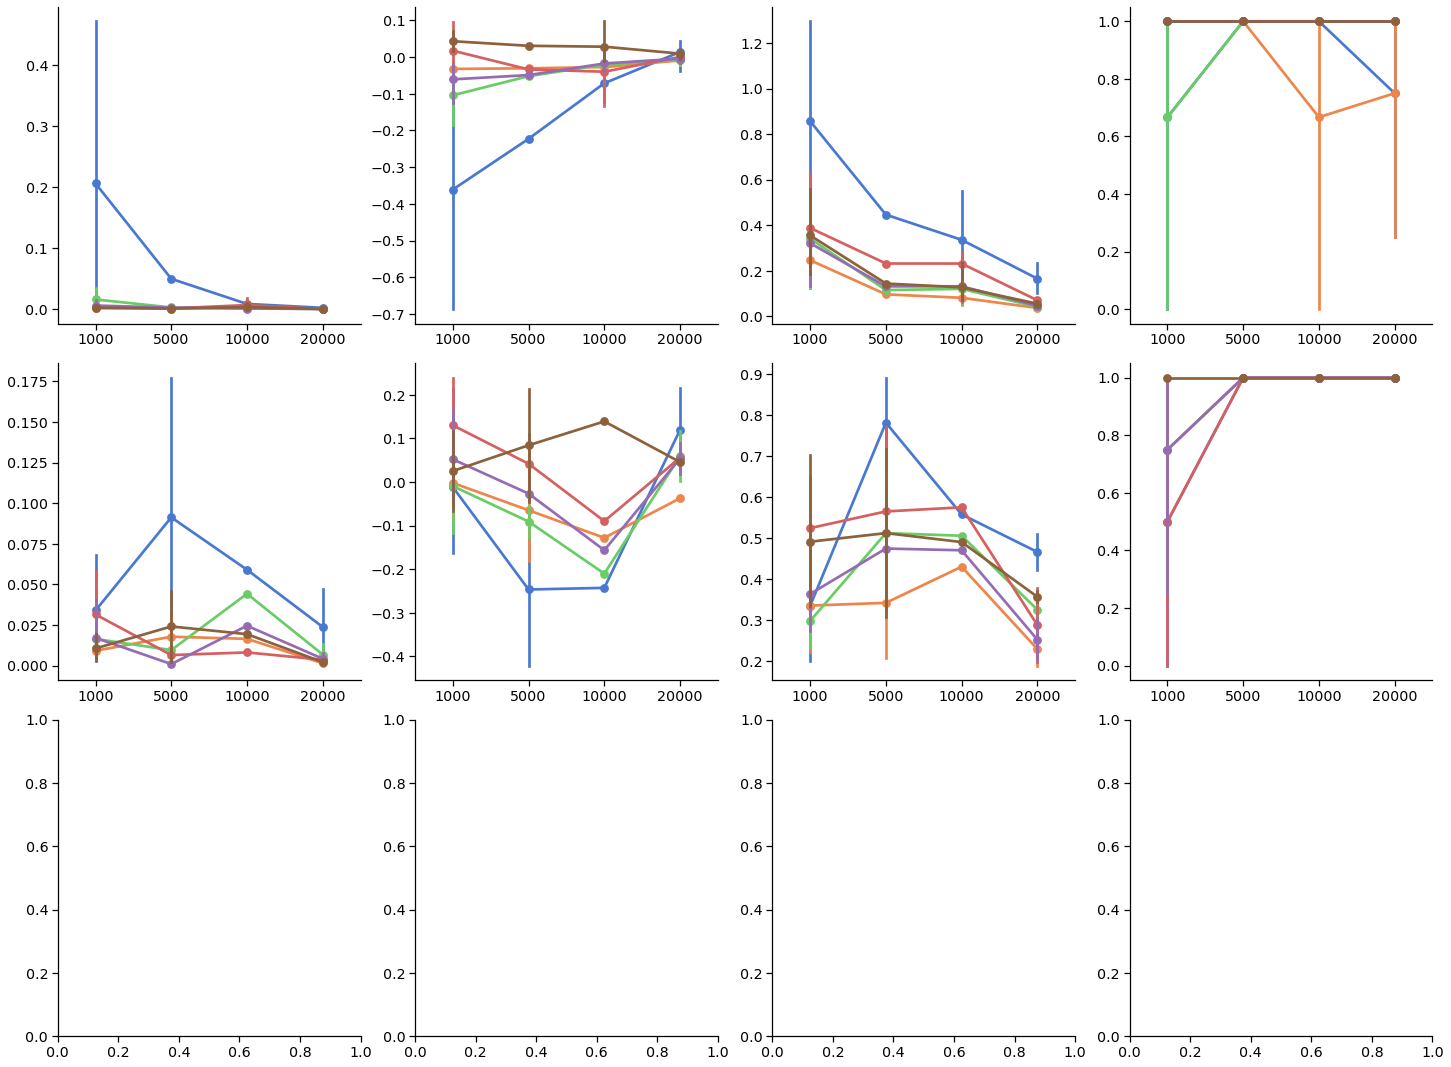

In [8]:
for alpha in decay_rates:
    display(HTML(f"<h2>Decay rate (alpha) = {alpha}</h2>"))
    plot_contrast(df.query(f"policy=='(0,2)' and floor_decay=={alpha}"))